## Import và tải dữ liệu

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:13<00:00, 79.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


### Import các thư viện cần thiết

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

In [3]:
annotations_dir = os.path.join(path, 'annotations')
images_dir = os.path.join(path, 'images')
print(annotations_dir)
print(images_dir)

/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1/annotations
/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1/images


In [4]:
def count_num_object(annotation_file):
    try:
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        count = 0
        for obj in root.findall('object'):
            count += 1
        return count
    except FileNotFoundError:
        return 0

def filter_images_one_object(images_dir, annotations_dir):
    image_files = []
    for img_file in os.listdir(images_dir):
        if os.path.isfile(os.path.join(images_dir, img_file)):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = os.path.join(annotations_dir, img_name+'.xml')
            num_obj = count_num_object(annotation_file)
            if num_obj <= 1:
                image_files.append(img_file)
    return image_files

In [5]:
dataset = filter_images_one_object(images_dir, annotations_dir)
print(len(dataset))

3685


In [6]:
dataset[:10]

['Cats_Test120.png',
 'Cats_Test3432.png',
 'Cats_Test3010.png',
 'Cats_Test2255.png',
 'Cats_Test1981.png',
 'Cats_Test2243.png',
 'Cats_Test82.png',
 'Cats_Test1673.png',
 'Cats_Test1734.png',
 'Cats_Test1525.png']

In [7]:
train_ds, val_ds = train_test_split(dataset,
                                    test_size=0.2,
                                    random_state=42)

In [8]:
print(len(train_ds))
print(len(val_ds))

2948
737


In [9]:
class ImageDataset(Dataset):
    def __init__(self, dataset, images_dir, annotations_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = dataset

    def get_label(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        label = None
        for obj in root.findall('object'):
            if label is None:
                label = obj.find('name').text
        label = 0 if label == 'cat' else 1 if label == 'dog' else -1
        return label

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        # annotation file
        annotation_file = img_name.split('.')[0]
        annotation_path = os.path.join(self.annotations_dir, annotation_file+'.xml')

        # get label
        label = self.get_label(annotation_path)

        # image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(train_ds,
                             images_dir,
                             annotations_dir,
                             transform)
val_dataset = ImageDataset(val_ds,
                           images_dir,
                           annotations_dir,
                           transform)

train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=128,
                        shuffle=False)

In [11]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


In [12]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = []
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            predicts = model(images)

            loss = criterion(predicts, labels)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
        train_losses.append(sum(losses) / len(losses))

        # validation
        model.eval()
        with torch.no_grad():
            losses_val = []
            correct = 0
            total = 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                predicts = model(images)
                loss = criterion(predicts, labels)
                losses_val.append(loss.item())
                _, labels_predict = predicts.max(1)
                correct += (labels_predict == labels).sum()
                total += labels.size(0)
            val_acc = (correct / total)*100
            val_losses.append(sum(losses_val) / len(losses_val))

            print(f'Epoch {epoch + 1}/{epochs}\tValidation Acc: {val_acc:.2f}%')

    return train_losses, val_losses


In [13]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10	Validation Acc: 93.22%
Epoch 2/10	Validation Acc: 96.20%
Epoch 3/10	Validation Acc: 88.74%
Epoch 4/10	Validation Acc: 94.17%
Epoch 5/10	Validation Acc: 94.44%
Epoch 6/10	Validation Acc: 93.22%
Epoch 7/10	Validation Acc: 92.54%
Epoch 8/10	Validation Acc: 92.40%
Epoch 9/10	Validation Acc: 89.15%
Epoch 10/10	Validation Acc: 94.30%


([0.19822866299849315,
  0.06923667108640075,
  0.1261470519724147,
  0.15635935954439142,
  0.06259400793351233,
  0.05019609738640914,
  0.1201110245116676,
  0.2345038472364346,
  0.1377044995315373,
  0.1246322412819912],
 [0.2635941505432129,
  0.15293366213639578,
  0.35558629781007767,
  0.17423894504706064,
  0.15595326324303946,
  0.18399749944607416,
  0.19127219542860985,
  0.26171545932690304,
  0.2527425065636635,
  0.1581479733188947])

#### Predict and show result

In [36]:
def predict(model, image, idx_to_class):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        class_logit = model(image)
    prob_predict_class, idx = nn.functional.softmax(class_logit, dim=1).max(dim=1)
    label_pred = idx_to_class[idx.item()]

    prob = prob_predict_class.item()
    return prob, label_pred

In [24]:
def get_label(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    label = None
    for obj in root.findall('object'):
        if label is None:
            label = obj.find('name').text
    return label

def process_img(img_path, transform):
    image = Image.open(img_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    return image

In [37]:
idx_to_class = {0: 'cat', 1: 'dog'}

img_file = 'Cats_Test1009.png'
annotation_file = 'Cats_Test1009.xml'
img_path = os.path.join(images_dir, img_file)
annotation_path = os.path.join(annotations_dir, annotation_file)

image = process_img(img_path, transform)
label = get_label(annotation_path)
prob, label_pred = predict(model, image, idx_to_class)

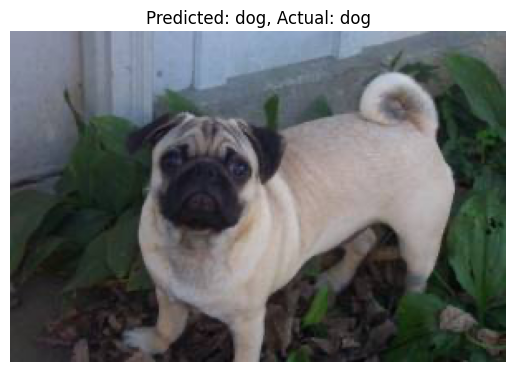

In [38]:
def show_result(img_path, true_label, label_pred):
    image = Image.open(img_path).convert('RGB')

    # Create a figure and an axis
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Display the plot
    plt.title(f"Predicted: {label_pred}, Actual: {true_label}")
    plt.axis('off')
    plt.show()

show_result(img_path, label, label_pred)